In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset,DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

torch.manual_seed(0)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
class MnistDataset(Dataset):
    def __init__(self,path,transform=None):
        #loading dataframe as data
        data=pd.read_csv(path)
        #x is for the 28x28 mnist digit image matrix
        self.x=data.iloc[:,1:].values
        #y is for the label
        self.y=data.iloc[:,0]
        #num_samples gives number of images
        self.num_samples=len(data)
        self.transform=transform
        
    def __getitem__(self,index):
        sample=self.x[index],np.array(self.y[index])
        if self.transform is not None:
            sample=self.transform(sample)
        return sample
    
    def __len__(self):
        return self.num_samples

class ToTensor:
    def __call__(self,sample):
        inputs,target=sample
        #from_numpy converts numpy arrays to tensors
        return torch.from_numpy(inputs),torch.from_numpy(target)

In [3]:
# Loading data from csv files
train_path='./Data/mnist_train.csv'
test_path='./Data/mnist_test.csv'
train_set=MnistDataset(train_path,transform=ToTensor())
test_set=MnistDataset(test_path,transform=ToTensor())

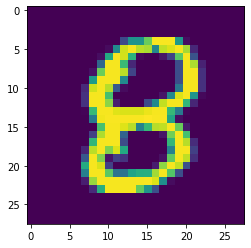

In [4]:
# plot train and test data
train_data=train_set[0]
plt.imshow(train_data[0].numpy().reshape(28,28))
test_data=test_set[0]
plt.imshow(test_data[0].numpy().reshape(28,28))

# Dataloader pytorch
train_loader=DataLoader(train_set,batch_size=32,shuffle=True)
test_loader=DataLoader(test_set,batch_size=32,shuffle=True)

# plot from data loader
plt.imshow(iter(train_loader).next()[0][1].reshape(28,28))

In [5]:
def softmax(x):
    exp_x = torch.exp(x)
    sum_x = torch.sum(exp_x, dim=1, keepdim=True)

    return exp_x/sum_x

def log_softmax(x):
    return torch.log(softmax(x))

# Custom-Cross-entropy
# def myCrossEntropyLoss(outputs, targets):
#     num_examples = targets.shape[0]
#     batch_size = outputs.shape[0]
#     outputs = log_softmax(outputs)
#     outputs = outputs[range(batch_size), targets]
 
#     return - torch.sum(outputs)/num_examples



# Modified VGG with additional fully connected layers and Dropouts
class CustomVGG(nn.Module):
    def __init__(self):
        super(CustomVGG, self).__init__()
        cfg = [64, 128, 'M', 256, 'M', 512, 'M']
        self.features = self._make_layers(cfg)
        self.classifier = self._classifier_layers()

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self,cfg):
        layers = []
        in_channels = 1
        
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=0),
                           nn.BatchNorm2d(x),
                           nn.LeakyReLU(0.2,inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        layers += [nn.Dropout(0.2)]
        return nn.Sequential(*layers)
    
    def _classifier_layers(self):
        layers = []
        layers += [nn.Dropout(0.5),
                   nn.Linear(512, 128),
                   nn.LeakyReLU(0.2,inplace=True),
                   nn.Dropout(0.5),
                   nn.Linear(128, 64),
                   nn.LeakyReLU(0.2,inplace=True),
                   nn.Dropout(0.5),
                   nn.Linear(64,10)]
        return nn.Sequential(*layers)
        
        
model=CustomVGG()
model.to(device)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope

In [6]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
test_labels = []

num_epochs = 10
def train(model, device,train_loader, optimizer, epoch):
    loss_tr = 0
    count = 0
    correct = 0
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1,1,28,28).float().to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss_tr += loss.item()
        count += 1
        loss.backward()
        optimizer.step()
        
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(target.view_as(pred)).sum().item()
        if(epoch == num_epochs-1):
          test_labels.append(pred.cpu().numpy())
    
    loss_tr /= count
    train_loss.append(loss_tr)
    train_acc.append(100. * correct / len(train_loader.dataset))
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        loss_tr,100. * correct / len(train_loader.dataset)))
        

def test(model,device, test_loader):
    model.eval()
    testloss = 0
    correct = 0
    count = 0
    test_label = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
    # Pytorch wont do autonmatic gradient computation for this section
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.reshape(-1,1,28,28).float().to(device)
            output = model(data)
            testloss += criterion(output, target).item()
            count += 1
            # Extracting index of max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
      
    testloss /= count
    test_loss.append(testloss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        testloss,100. * correct / len(test_loader.dataset)))
    print(50*"-")

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.02)

for epoch in range(1, num_epochs):
    print("Epoch : ", epoch)
    train(model,device, train_loader, optimizer, epoch)
    test(model,device, test_loader)

Epoch :  1

Train set: Average loss: 0.2705, Accuracy: 92%

Test set: Average loss: 0.0438, Accuracy: 99%

--------------------------------------------------
Epoch :  2

Train set: Average loss: 0.1097, Accuracy: 97%

Test set: Average loss: 0.0486, Accuracy: 98%

--------------------------------------------------
Epoch :  3

Train set: Average loss: 0.0864, Accuracy: 98%

Test set: Average loss: 0.0363, Accuracy: 99%

--------------------------------------------------
Epoch :  4

Train set: Average loss: 0.0702, Accuracy: 98%

Test set: Average loss: 0.0321, Accuracy: 99%

--------------------------------------------------
Epoch :  5

Train set: Average loss: 0.0599, Accuracy: 98%

Test set: Average loss: 0.0357, Accuracy: 99%

--------------------------------------------------
Epoch :  6

Train set: Average loss: 0.0523, Accuracy: 99%

Test set: Average loss: 0.0297, Accuracy: 99%

--------------------------------------------------
Epoch :  7

Train set: Average loss: 0.0454, Accurac

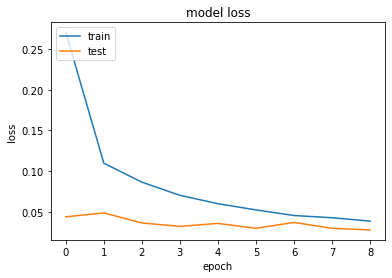

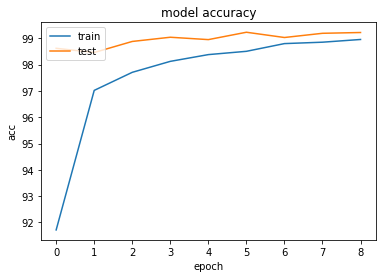

98.95498258304305
99.21992199219922


In [8]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(train_acc[-1])
print(test_acc[-1])